In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import expit
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

import sympy as sp

# DGP

$$
r^*(p) = x\theta + w
$$

$$
r(r*) = \dfrac{1}{1+e^{r^*}}
$$

$$
amt(r^*) = a + b r^*
$$

$$
loss(r^*) = amt(r^*)r(r*)
$$

$$
rev(r^*) = amt(r^*)((x+1)^n - 1)
$$


In [505]:
def sample_sparse_coefs(nx, p=0.8):
    return np.random.uniform(-1, 1, nx)*np.random.binomial(1, p, nx)
    
    
def sample_from(dist, mu, var, n):
    if dist == "gamma":
        return np.random.gamma(mu**2/var, np.abs(var/mu), n)
    
    if dist == "normal":
        return np.random.normal(mu, np.sqrt(var), n)
    
    if dist == "uniform":
        a = mu-np.sqrt(3 * var)
        return np.random.uniform(a, 2*mu - a, n)
    

def risk_fn(risk_latent):
    return expit(risk_latent)


def sample_default(risk):
    return np.random.binomial(1, risk)


def sample_loan_amt(base_latent_risk):
    return np.random.normal(15000 + 500*base_latent_risk).clip(500)


def sample_installments(base_latent_risk):
    mu = np.clip(5+((base_latent_risk-base_latent_risk.mean())/base_latent_risk.std()), 0, np.inf)
    return np.random.poisson(mu*2)+1
    

def first_default(arr, axis):
    mask = arr!=1
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), arr.shape[1])


def defaulted_at_period(risk, periods, default_cutoff):
    survival = np.power(1-risk, 1/periods)
    max_period = periods.max()
    
    survival_probs = survival.reshape(-1,1)**np.arange(1, max_period+1).reshape(1, -1)
    default_sequence = (1 - survival_probs) < default_cutoff.reshape(-1,1)
    
    survived_up_to = first_default(default_sequence, 1)
    
    return np.clip(survived_up_to, 0, periods)
    

    
class LendingWorld(object):
    
    
    def __init__(self, nx=10, poly=2, bias=1, temp=0.01, seed=123):
        
        np.random.seed(seed)

        self.NX = nx
        self.POLY = poly
        self.POLY_GEN = PolynomialFeatures(self.POLY, include_bias=False)
        
        self.MUS = np.random.uniform(-2, 2, self.NX)
        self.VARS = np.random.exponential(1, self.NX)
        self.DISTS = np.random.choice(["normal"], self.NX)
        
        poly_mu = self.POLY_GEN.fit_transform(self.MUS.reshape(1, -1))
        
        self.NX_FINAL = poly_mu.shape[1]
        
        self.RISK_COEFS = sample_sparse_coefs(self.NX_FINAL)
        self.RISK_SENS_COEFS = sample_sparse_coefs(self.NX_FINAL)
        
        self.RISK_MU = poly_mu.dot(self.RISK_COEFS).mean()
        self.RISK_SENS_MU = poly_mu.dot(self.RISK_SENS_COEFS).mean()
        
        self.temp = temp
        self.bias = bias
        
        self.features = [f"col_{i+1}" for i in range(self.NX)]

    
    def baseline_risk_fn(self, x):
        return x.dot(self.RISK_COEFS) - self.RISK_MU
    
    
    def sample_risk_sens_fn(self, x):
        return x.dot(self.RISK_SENS_COEFS) - self.RISK_SENS_MU + 50
    
    
    def risk_latent_fn(self, x, price, risk_sens):
        return self.baseline_risk_fn(x)*0.2 + risk_sens*price - 2
    
    
    def sample_features(self, n):
        X = np.hstack([sample_from(dist, mu, var, n).reshape(-1, 1)
                       for dist, mu, var in zip(self.DISTS, self.MUS, self.VARS)])
        
        X_poly = self.POLY_GEN.fit_transform(X)
        
        baseline_risk = self.baseline_risk_fn(X_poly)
        loan_amt = sample_loan_amt(baseline_risk)
        installments = sample_installments(baseline_risk)
        
        default_cutoff = np.random.uniform(0, 1, n)
        
        return (pd.DataFrame(X, columns=self.features)
                .assign(loan_amt = loan_amt,
                        installments=installments,
                        default_cutoff=default_cutoff))

    
    def outcome_fn(self, df, price):
        
        X = df[self.features]
        X_poly = self.POLY_GEN.fit_transform(X)
        
        risk_sens = self.sample_risk_sens_fn(X_poly)
        risk_latent = self.risk_latent_fn(X_poly, price, risk_sens)
        risk = risk_fn(risk_latent)
        
        survived_up_to = defaulted_at_period(risk, df["installments"].values, df["default_cutoff"].values)
        interest_revenues = df["loan_amt"]*((1+price)**survived_up_to - 1)
        
        default = (survived_up_to < df["installments"])*1
        loss = default*df["loan_amt"]
        
        margin = interest_revenues - loss
        
        return df.assign(**dict(
            price=price,
            risk=risk,
            
            risk_baseline=self.baseline_risk_fn(X_poly), 
            risk_sens=risk_sens,
            risk_latent=risk_latent,
            
            interest_revenues=interest_revenues,
            survived_up_to=survived_up_to,
            default=default,
            loss=loss,
            
            margin = margin
        ))

    

world = LendingWorld(seed=1)

In [506]:
price_space = np.arange(.01, .1, .01)

loans = world.sample_features(n=5)
output = world.outcome_fn(loans, np.random.choice(price_space, len(loans)))
output

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,price,risk,risk_baseline,risk_sens,risk_latent,interest_revenues,survived_up_to,default,loss,margin
0,-1.243616,1.020097,-2.582887,-1.085746,-1.433051,-0.761391,-1.887948,-1.798706,-0.270450,-0.129940,...,0.08,0.676646,-2.471016,40.407568,0.738402,0.000000,0,1,13764.626118,-13764.626118
1,0.313683,2.619710,-0.828129,-0.438615,-1.618466,-2.155565,-0.759108,-0.929776,-0.819211,0.205177,...,0.08,0.990914,11.006532,56.131781,4.691849,1640.357452,1,1,20504.468145,-18864.110693
2,0.127578,1.421804,-2.260560,-0.497863,-1.610001,-1.958300,-0.800389,-0.826537,0.384850,-0.561597,...,0.04,0.524405,0.357109,50.656861,0.097696,11105.999046,14,0,0.000000,11105.999046
3,-0.652525,2.557199,-2.094637,0.168310,-1.523919,-1.632638,-1.580650,-3.143928,-0.185144,0.528822,...,0.09,0.960287,7.158781,41.708949,3.185562,5481.536412,3,1,18579.652890,-13098.116478
4,0.705608,0.998919,-2.334509,1.809317,-1.691968,-3.102130,0.075619,1.134617,-0.245871,-0.020669,...,0.04,0.894693,10.026713,53.356390,2.139598,3399.486866,4,1,20013.632905,-16614.146040


In [507]:
np.random.seed(1)
output_exp = pd.concat([world.outcome_fn(loans.reset_index(), np.random.choice([p], len(loans)))
                        for p in price_space
                       ]).reset_index(drop=True)



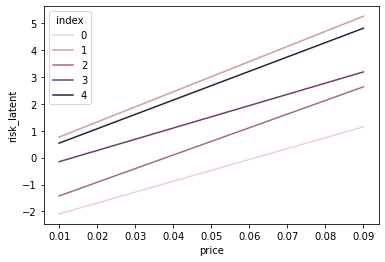

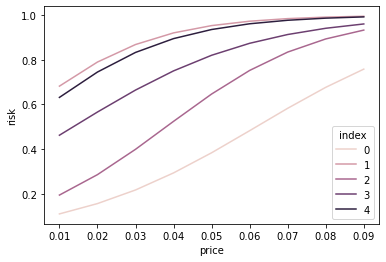

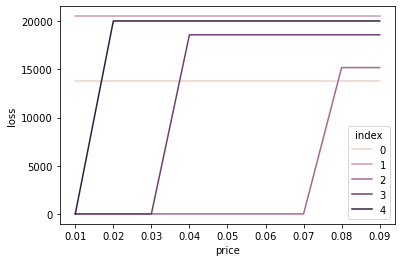

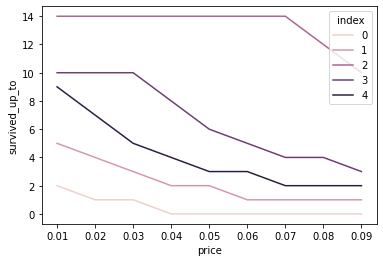

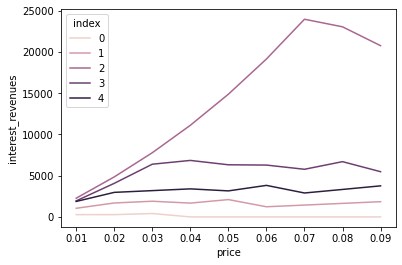

In [508]:
sns.lineplot(data=output_exp, x="price", y="risk_latent", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="risk", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="loss", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="survived_up_to", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="interest_revenues", hue="index")
plt.show()

In [509]:
price_space = np.arange(.01, .1, .01)

features = world.features

loans = world.sample_features(n=50000)
output = world.outcome_fn(loans, np.random.choice(price_space, len(loans)))

output.mean()

col_1                   -0.329119
col_2                    0.888520
col_3                   -1.998780
col_4                   -0.782292
col_5                   -1.413277
col_6                   -1.633019
col_7                   -1.252065
col_8                   -0.623146
col_9                   -0.414415
col_10                   0.156681
loan_amt             14983.064313
installments            10.987060
default_cutoff           0.501360
price                    0.049945
risk                     0.585449
risk_baseline           -0.053798
risk_sens               50.843773
risk_latent              0.528204
interest_revenues     4906.058535
survived_up_to           6.268760
default                  0.584720
loss                  9609.988135
margin               -4703.929600
dtype: float64

In [510]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

rev_model = LGBMRegressor()
loss_model = LGBMRegressor()

X = output[features+["price"]]
rev_model.fit(X, output["interest_revenues"])
loss_model.fit(X, output["loss"])

print(rev_model.score(X, output["interest_revenues"]))
print(loss_model.score(X, output["loss"]))

r2_score(output["margin"], rev_model.predict(X) - loss_model.predict(X))

0.23173409134861056
0.5480717051061469


0.2977519072161928

In [511]:
np.random.seed(2)
new_sample = world.sample_features(n=50000)

price_alocation_sample = (new_sample.reset_index()
                          .assign(key=1)
                          .merge(pd.DataFrame(dict(price=price_space, key=1)))
                          .assign(loss_pred = lambda d: -loss_model.predict(d[features+["price"]]))
                          .assign(rev_pred = lambda d: rev_model.predict(d[features+["price"]]))
                          .assign(prediction = lambda d: rev_model.predict(d[features+["price"]]) - loss_model.predict(d[features+["price"]]))
                          .sort_values(["index", "prediction"], ascending=(True, False))
                          .groupby(["index"])
                          .first()
                         )

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

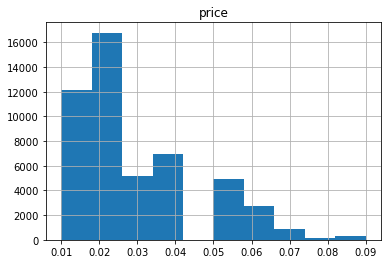

In [512]:
price_alocation_sample[["price"]].hist()

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

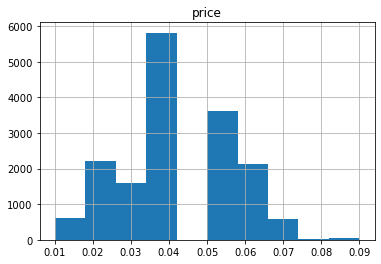

In [513]:
price_alocation_sample.query("prediction>0")[["price"]].hist()